In [1]:
# pip install sklearn
# sklearn.__version__
# !pip install -U scikit-learn==1.1.0

# Define Functions

In [2]:
import random
import numpy as np

from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score


import pandas as pd
from sklearn.utils import shuffle
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers, models
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import time
import sklearn
# import seaborn as sns

from wakepy import set_keepawake, unset_keepawake
set_keepawake(keep_screen_awake=True)

def value2int(y, clusters=2):
    label = np.copy(y)
    label[y < np.percentile(y, 100 / clusters)] = 0
    for i in range(1, clusters):
        label[y > np.percentile(y, 100 * i / clusters)] = i
    return label

def value2int_simple(y):
    label = np.copy(y)
    label[y < 0] = 0
    label[y >= 0] = 1
    return label

def get_Feature_Label(clusters=2, files=[]):
    ##### train #####
    data = pd.DataFrame()

    for file in files:
        data = pd.concat([data, pd.read_csv(file)])
    
    shuffle(data)
    X, y = data.iloc[:, 1:-1], data.iloc[:, -1]
    y = value2int_simple(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

    X_train, y_train = SMOTE().fit_resample(X_train, y_train)
    X_train, y_train = TomekLinks().fit_resample(X_train, y_train)

    y = to_categorical(y).astype("int")
    y_train = to_categorical(y_train).astype("int")
    y_valid = to_categorical(y_valid).astype("int")
    y_test = to_categorical(y_test).astype("int")
    
    X = X.values.reshape(X.shape[0], 30, 100, 1).astype('float32')
    X_train = X_train.values.reshape(X_train.shape[0], 30, 100, 1).astype('float32')
    X_valid = X_valid.values.reshape(X_valid.shape[0], 30, 100, 1).astype('float32')
    X_test = X_test.values.reshape(X_test.shape[0], 30, 100, 1).astype('float32')

    return X, y, X_train, y_train, X_valid, y_valid, X_test, y_test

def CNN(clusters=2):
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 100), activation='relu', input_shape=(30, 100, 1))) # output channel, kernel size, input shape, input channel
    model.add(layers.MaxPooling2D((28, 1))) # 30-3+1 = 28 !!!
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(clusters, activation='softmax'))
#     sgd = keras.optimizers.SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])
    return model

def evaluate(model, X_train, y_train, X_valid, y_valid, X_test, y_test):
    
    model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, batch_size=1024, verbose=0)
    score = model.evaluate(X_test, y_test, verbose=0) # return [loss, acc]
    print('Score: ', score, end='   ')

    predictions = model.predict(X_test)
    thres = 0.75
    y_cut = (predictions[:,0] > thres) | (predictions[:,1] > thres) # cut y value and leave the better result
    predictions_2 = np.argmax(predictions[y_cut], axis=-1)
    conf = confusion_matrix(np.argmax(y_test[y_cut], axis=-1), predictions_2)
    print('Test Precision: ', (conf[0,0]+conf[1,1])/sum(sum(conf)))
    
    return model

In [3]:
def clearSentence(sentence):
    sentence = re.sub('-KY', '', sentence)
    sentence = re.sub('\*', '', sentence)
    return sentence

In [4]:
def find_coid(df):
    for idx in range(1500):
        gap = sum(df[[29+i*30 for i in range(100) ]].values - wordEmbedding[idx])
        if abs(gap) < 1e-12:
#             print(list(word2idx.keys())[idx])
            return coid_stock.loc[coid_stock['簡稱'] == list(word2idx.keys())[idx], '證券代碼']

In [5]:
import json
def readGlove(we_file):
    wordVec = np.zeros([0,100])
    with open(we_file) as file:
        for line in file:
            line = line.strip().split()
            line = list(map(float,line))
            wordVec = np.vstack((wordVec,np.array(line).flatten()))
    return wordVec

with open("./input2/word2idx.json") as data_file:
    word2idx = json.load(data_file)
    
wordEmbedding = readGlove('./input2/wordEmbeddingsVocab.csv')

# Create DataFrame Structure

In [6]:
import datetime
import re

candidatePoolDF = pd.read_csv('/Users/arthur/Desktop/factor_investment/data/StockValidation.csv')
candidatePool=list(candidatePoolDF['stock_id'])
candidatePool=[str(x) for x in candidatePool]



col_list = ["證券代碼", "簡稱", "年月日", "收盤價(元)"]
price = pd.read_csv('/Users/arthur/Desktop/factor_investment/data/TEJ_StockPrice_20052022.csv', encoding='big5', encoding_errors='ignore', usecols=col_list)
price["證券代碼"] = [str(x).strip() for x in price["證券代碼"]]
price["簡稱"] = [x.strip() for x in price["簡稱"]]
price.年月日 = pd.to_datetime(price.年月日).dt.date
price = price[price.年月日 > datetime.date(2012,12,31)].reset_index(drop=True)
price = price[price.年月日 < datetime.date(2022,1,1)].reset_index(drop=True)

coid_stock = price[["證券代碼", "簡稱"]].drop_duplicates().reset_index(drop=True)
del price

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/3768398774.py:11: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  price = pd.read_csv('/Users/arthur/Desktop/factor_investment/data/TEJ_StockPrice_20052022.csv', encoding='big5', encoding_errors='ignore', usecols=col_list)


In [7]:
coid_stock['簡稱'] = coid_stock['簡稱'].apply(lambda x: clearSentence(x))
coid_stock = coid_stock[coid_stock.證券代碼.isin(candidatePool)]
coid_stock = coid_stock.sort_values(by='證券代碼').reset_index(drop=True)

In [8]:
coid_stock

,證券代碼,簡稱
0,1101,台泥
1,1102,亞泥
2,1103,嘉泥
3,1104,環泥
4,1108,幸福
...,...,...
1116,9946,三發地產
1117,9951,皇田
1118,9955,佳龍
1119,9957,燁聯


In [48]:
dateList = []

for i in range(2013, 2022):
    for j in [4, 6, 9, 12]:
        dateList.append(datetime.date(i, j, 1)-datetime.timedelta(days=1))
        
WB_Score = pd.DataFrame(index=dateList, columns=set(coid_stock['證券代碼'].values))

In [49]:
WB_Score

,3450,1583,2380,3504,3661,9951,1321,4977,3438,3044,...,3536,1308,8255,3703,5264,2402,56,2524,5280,2352
2013-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
np.append(WB_Score.loc[datetime.date(2013,3,31), '1101'], 0.1)

array([nan, 0.1])

### （新舊一起餵）

In [12]:
def find_coid(lst):
    for idx in range(1500):
        gap = sum(lst - wordEmbedding[idx])
        if abs(gap) < 1e-6:
            return coid_stock.loc[coid_stock['簡稱'] == list(word2idx.keys())[idx], '證券代碼']
    return ''

In [13]:
# for test_i in range(test.shape[0]):
#     test_tmp = test[test_i].flatten()[[29+i*30 for i in range(100)]]
#     coid = find_coid(test_tmp)
#     if len(coid) > 0:
#         print(coid.values[0])
#     else:
#         print('Not Found')

In [50]:
### Load test data

# 3: 12, 1, 2, 3 => 4, 5
# 5: 4, 5 => 6, 7, 8
# 8: 6, 7, 8 => 9, 10 ,11
# 11: 9, 10 ,11 => 12, 1, 2, 3

# print(len(y_test))
loc = './input2/stockFeatures_ForCNN/'
model = CNN(2)

FP = []

### Start training

for year in range(2013, 2022):
    for month in [3, 5, 8, 11]: # 3, 5, 8, 11 -> 4, 6, 9, 12
        
        data_files = []

        if month == 3:
            ### training ###
            print('Year: ', year, 'Month: ', month)
            loc = './input2/stockFeatures_ForCNN/' + str(year-1) + '/' + str(12) + '/'
            data_files = [loc+f for f in os.listdir(loc) if f.endswith('csv')]
            
            for i in [1, 2, 3]:
                loc = './input2/stockFeatures_ForCNN/' + str(year) + '/' + str(i) + '/'
                data_files += [loc+f for f in os.listdir(loc) if f.endswith('csv')]
            
            data_files = sorted(data_files)

            X, y, X_train, y_train, X_valid, y_valid, X_test, y_test = get_Feature_Label(clusters=2, files=data_files)
            model = evaluate(model, X_train, y_train, X_valid, y_valid, X_test, y_test)
            
            ### generate factor values ###
            factorValues = model.predict(X)
            for factor_i in range(factorValues.shape[0]):
                X_tmp = X[factor_i].flatten()[[29+i*30 for i in range(100)]]
                coid = find_coid(X_tmp)
                if len(coid) > 0:
                    coid = coid.values[0]
                else:
                    print('NF', end='  ')
                    continue
                WB_Score.loc[datetime.date(year,3,31), coid] = np.append(WB_Score.loc[datetime.date(year,3,31), coid], factorValues[factor_i, 1])
                
#             WB_Score = WB_Score.apply(lambda x: np.nanmean(x))
            for coid_idx in WB_Score.columns:
                WB_Score.loc[datetime.date(year,3,31), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,3,31), coid_idx] )
                
            del X, y, X_train, y_train, X_valid, y_valid, X_test, y_test
            
#             ### prediction ###
#             data_files = []
#             for i in [4, 5]:
#                 loc = './input2/stockFeatures_ForCNN/' + str(year) + '/' + str(i) + '/'
#                 data_files += [loc+f for f in os.listdir(loc) if f.endswith('csv')]
#             data = pd.DataFrame()

#             for file in data_files:
#                 data = pd.concat([data, pd.read_csv(file)])

#             X, y = data.iloc[:, 1:-1], data.iloc[:, -1]
#             y = value2int_simple(y)
#             print('Forward Positive Rate: ', sum(y)/len(y), end='   ')
#             y = to_categorical(y).astype("int")
#             X = X.values.reshape(X.shape[0], 30, 100, 1).astype('float32')
            
#             predictions = model.predict(X)
#             thres = 0.75
#             y_cut = (predictions[:,0] > thres) | (predictions[:,1] > thres) # cut y value and leave the better result
#             predictions_2 = np.argmax(predictions[y_cut], axis=-1)
#             conf = confusion_matrix(np.argmax(y[y_cut], axis=-1), predictions_2)
#             print('Forward Accuracy: ', (conf[0,0]+conf[1,1])/sum(sum(conf)))
#             FP.append((conf[0,0]+conf[1,1])/sum(sum(conf)))
        
        elif month == 5:
            ### training ###
            print('Year: ', year, 'Month: ', month)
            data_files = []
            
            for i in [4, 5]:
                loc = './input2/stockFeatures_ForCNN/' + str(year) + '/' + str(i) + '/'
                data_files += [loc+f for f in os.listdir(loc) if f.endswith('csv')]
            
            data_files = sorted(data_files)

            X, y, X_train, y_train, X_valid, y_valid, X_test, y_test = get_Feature_Label(clusters=2, files=data_files)
            model = evaluate(model, X_train, y_train, X_valid, y_valid, X_test, y_test)
            
            ### generate factor values ###
            factorValues = model.predict(X)
            for factor_i in range(factorValues.shape[0]):
                X_tmp = X[factor_i].flatten()[[29+i*30 for i in range(100)]]
                coid = find_coid(X_tmp)
                if len(coid) > 0:
                    coid = coid.values[0]
                else:
                    print('NF', end='  ')
                    continue
                WB_Score.loc[datetime.date(year,5,31), coid] = np.append(WB_Score.loc[datetime.date(year,5,31), coid], factorValues[factor_i, 1])

#             WB_Score = WB_Score.apply(lambda x: np.nanmean(x))
            for coid_idx in WB_Score.columns:
                WB_Score.loc[datetime.date(year,5,31), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,5,31), coid_idx] )
            del X, y, X_train, y_train, X_valid, y_valid, X_test, y_test
            
#             ### prediction ###
#             data_files = []
#             for i in [6, 7, 8]:
#                 loc = './input2/stockFeatures_ForCNN/' + str(year) + '/' + str(i) + '/'
#                 data_files += [loc+f for f in os.listdir(loc) if f.endswith('csv')]
#             data = pd.DataFrame()

#             for file in data_files:
#                 data = pd.concat([data, pd.read_csv(file)])

#             X, y = data.iloc[:, 1:-1], data.iloc[:, -1]
#             y = value2int_simple(y)
#             print('Forward Positive Rate: ', sum(y)/len(y), end='   ')
#             y = to_categorical(y).astype("int")
#             X = X.values.reshape(X.shape[0], 30, 100, 1).astype('float32')
            
#             predictions = model.predict(X)
#             thres = 0.75
#             y_cut = (predictions[:,0] > thres) | (predictions[:,1] > thres) # cut y value and leave the better result
#             predictions_2 = np.argmax(predictions[y_cut], axis=-1)
#             conf = confusion_matrix(np.argmax(y[y_cut], axis=-1), predictions_2)
#             print('Forward Accuracy: ', (conf[0,0]+conf[1,1])/sum(sum(conf)))
#             FP.append((conf[0,0]+conf[1,1])/sum(sum(conf)))

        elif month == 8:
            ### training ###
            print('Year: ', year, 'Month: ', month)
            data_files = []
            
            for i in [6, 7, 8]:
                loc = './input2/stockFeatures_ForCNN/' + str(year) + '/' + str(i) + '/'
                data_files += [loc+f for f in os.listdir(loc) if f.endswith('csv')]
            
            data_files = sorted(data_files)

            X, y, X_train, y_train, X_valid, y_valid, X_test, y_test = get_Feature_Label(clusters=2, files=data_files)
            model = evaluate(model, X_train, y_train, X_valid, y_valid, X_test, y_test)
            
            ### generate factor values ###
            factorValues = model.predict(X)
            for factor_i in range(factorValues.shape[0]):
                X_tmp = X[factor_i].flatten()[[29+i*30 for i in range(100)]]
                coid = find_coid(X_tmp)
                if len(coid) > 0:
                    coid = coid.values[0]
                else:
                    print('NF', end='  ')
                    continue
                WB_Score.loc[datetime.date(year,8,31), coid] = np.append(WB_Score.loc[datetime.date(year,8,31), coid], factorValues[factor_i, 1])
            
#             WB_Score = WB_Score.apply(lambda x: np.nanmean(x))
            for coid_idx in WB_Score.columns:
                WB_Score.loc[datetime.date(year,8,31), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,8,31), coid_idx] )
            del X, y, X_train, y_train, X_valid, y_valid, X_test, y_test
#             ### prediction ###
#             data_files = []
#             for i in [9, 10, 11]:
#                 loc = './input2/stockFeatures_ForCNN/' + str(year) + '/' + str(i) + '/'
#                 data_files += [loc+f for f in os.listdir(loc) if f.endswith('csv')]
#             data = pd.DataFrame()

#             for file in data_files:
#                 data = pd.concat([data, pd.read_csv(file)])

#             X, y = data.iloc[:, 1:-1], data.iloc[:, -1]
#             y = value2int_simple(y)
#             print('Forward Positive Rate: ', sum(y)/len(y), end='   ')
#             y = to_categorical(y).astype("int")
#             X = X.values.reshape(X.shape[0], 30, 100, 1).astype('float32')
            
#             predictions = model.predict(X)
#             thres = 0.75
#             y_cut = (predictions[:,0] > thres) | (predictions[:,1] > thres) # cut y value and leave the better result
#             predictions_2 = np.argmax(predictions[y_cut], axis=-1)
#             conf = confusion_matrix(np.argmax(y[y_cut], axis=-1), predictions_2)
#             print('Forward Accuracy: ', (conf[0,0]+conf[1,1])/sum(sum(conf)))
#             FP.append((conf[0,0]+conf[1,1])/sum(sum(conf)))
            
        elif month == 11:
            ### training ###
            print('Year: ', year, 'Month: ', month)
            data_files = []
            
            for i in [9, 10, 11]:
                loc = './input2/stockFeatures_ForCNN/' + str(year) + '/' + str(i) + '/'
                data_files += [loc+f for f in os.listdir(loc) if f.endswith('csv')]
            
            data_files = sorted(data_files)

            X, y, X_train, y_train, X_valid, y_valid, X_test, y_test = get_Feature_Label(clusters=2, files=data_files)
            model = evaluate(model, X_train, y_train, X_valid, y_valid, X_test, y_test)
            
            ### generate factor values ###
            factorValues = model.predict(X)
            for factor_i in range(factorValues.shape[0]):
                X_tmp = X[factor_i].flatten()[[29+i*30 for i in range(100)]]
                coid = find_coid(X_tmp)
                if len(coid) > 0:
                    coid = coid.values[0]
                else:
                    print('NF', end='  ')
                    continue
                WB_Score.loc[datetime.date(year,11,30), coid] = np.append(WB_Score.loc[datetime.date(year,11,30), coid], factorValues[factor_i, 1])
            
#             WB_Score = WB_Score.apply(lambda x: np.nanmean(x))
            for coid_idx in WB_Score.columns:
                WB_Score.loc[datetime.date(year,11,30), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,11,30), coid_idx] )
            del X, y, X_train, y_train, X_valid, y_valid, X_test, y_test
            
            
#             ### prediction ###
#             loc = './input2/stockFeatures_ForCNN/' + str(year) + '/' + str(12) + '/'
#             data_files = [loc+f for f in os.listdir(loc) if f.endswith('csv')]
            
#             for i in [1, 2, 3]:
#                 loc = './input2/stockFeatures_ForCNN/' + str(year+1) + '/' + str(i) + '/'
#                 data_files += [loc+f for f in os.listdir(loc) if f.endswith('csv')]
#             data = pd.DataFrame()

#             for file in data_files:
#                 data = pd.concat([data, pd.read_csv(file)])

#             X, y = data.iloc[:, 1:-1], data.iloc[:, -1]
#             y = value2int_simple(y)
#             print('Forward Positive Rate: ', sum(y)/len(y), end='   ')
#             y = to_categorical(y).astype("int")
#             X = X.values.reshape(X.shape[0], 30, 100, 1).astype('float32')
            
#             predictions = model.predict(X)
#             thres = 0.75
#             y_cut = (predictions[:,0] > thres) | (predictions[:,1] > thres) # cut y value and leave the better result
#             predictions_2 = np.argmax(predictions[y_cut], axis=-1)
#             conf = confusion_matrix(np.argmax(y[y_cut], axis=-1), predictions_2)
#             print('Forward Accuracy: ', (conf[0,0]+conf[1,1])/sum(sum(conf)))
#             FP.append((conf[0,0]+conf[1,1])/sum(sum(conf)))

Year:  2013 Month:  3
Score:  [0.8072348237037659, 0.6176922917366028]   Test Precision:  0.6689102564102564
NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF 

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/1360356385.py:50: RuntimeWarning: Mean of empty slice
  WB_Score.loc[datetime.date(year,3,31), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,3,31), coid_idx] )


Year:  2013 Month:  5
Score:  [0.8461667895317078, 0.6045454740524292]   Test Precision:  0.6551465063861758
NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF 

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/1360356385.py:106: RuntimeWarning: Mean of empty slice
  WB_Score.loc[datetime.date(year,5,31), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,5,31), coid_idx] )


Year:  2013 Month:  8
Score:  [0.7984244227409363, 0.624193549156189]   Test Precision:  0.671183628318584
NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  N

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/1360356385.py:161: RuntimeWarning: Mean of empty slice
  WB_Score.loc[datetime.date(year,8,31), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,8,31), coid_idx] )


Year:  2013 Month:  11
Score:  [0.8137054443359375, 0.5889999866485596]   Test Precision:  0.6289954337899544
NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/1360356385.py:215: RuntimeWarning: Mean of empty slice
  WB_Score.loc[datetime.date(year,11,30), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,11,30), coid_idx] )


Year:  2014 Month:  3
Score:  [0.805877685546875, 0.5583750009536743]   Test Precision:  0.599477958236659
NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  N

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/1360356385.py:50: RuntimeWarning: Mean of empty slice
  WB_Score.loc[datetime.date(year,3,31), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,3,31), coid_idx] )


Year:  2014 Month:  5
Score:  [0.8543503880500793, 0.572954535484314]   Test Precision:  0.6298373527762199
NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/1360356385.py:106: RuntimeWarning: Mean of empty slice
  WB_Score.loc[datetime.date(year,5,31), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,5,31), coid_idx] )


Year:  2014 Month:  8
Score:  [0.758709728717804, 0.5701666474342346]   Test Precision:  0.6599439775910364
NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/1360356385.py:161: RuntimeWarning: Mean of empty slice
  WB_Score.loc[datetime.date(year,8,31), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,8,31), coid_idx] )


Year:  2014 Month:  11
Score:  [0.7814024090766907, 0.5787500143051147]   Test Precision:  0.6539365452408931
NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/1360356385.py:215: RuntimeWarning: Mean of empty slice
  WB_Score.loc[datetime.date(year,11,30), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,11,30), coid_idx] )


Year:  2015 Month:  3
Score:  [0.8064462542533875, 0.5496249794960022]   Test Precision:  0.6335598536330371
NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF 

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/1360356385.py:50: RuntimeWarning: Mean of empty slice
  WB_Score.loc[datetime.date(year,3,31), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,3,31), coid_idx] )


Year:  2015 Month:  5
Score:  [0.8057651519775391, 0.5521875023841858]   Test Precision:  0.6349534643226473
NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/1360356385.py:106: RuntimeWarning: Mean of empty slice
  WB_Score.loc[datetime.date(year,5,31), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,5,31), coid_idx] )


Year:  2015 Month:  8
Score:  [0.7457764148712158, 0.5994230508804321]   Test Precision:  0.702030124426981
NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/1360356385.py:161: RuntimeWarning: Mean of empty slice
  WB_Score.loc[datetime.date(year,8,31), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,8,31), coid_idx] )


Year:  2015 Month:  11
Score:  [0.7439191937446594, 0.5878787636756897]   Test Precision:  0.7096774193548387
NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/1360356385.py:215: RuntimeWarning: Mean of empty slice
  WB_Score.loc[datetime.date(year,11,30), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,11,30), coid_idx] )


Year:  2016 Month:  3
Score:  [0.7782449722290039, 0.5851389169692993]   Test Precision:  0.6981236203090507
NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF 

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/1360356385.py:50: RuntimeWarning: Mean of empty slice
  WB_Score.loc[datetime.date(year,3,31), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,3,31), coid_idx] )


Year:  2016 Month:  5
Score:  [0.7282928824424744, 0.5873529314994812]   Test Precision:  0.688504326328801
NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/1360356385.py:106: RuntimeWarning: Mean of empty slice
  WB_Score.loc[datetime.date(year,5,31), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,5,31), coid_idx] )


Year:  2016 Month:  8
Score:  [0.6793898940086365, 0.6074073910713196]   Test Precision:  0.7648839556004037
NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF 

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/1360356385.py:161: RuntimeWarning: Mean of empty slice
  WB_Score.loc[datetime.date(year,8,31), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,8,31), coid_idx] )


Year:  2016 Month:  11
Score:  [0.7027963995933533, 0.593479573726654]   Test Precision:  0.7528795811518325
NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/1360356385.py:215: RuntimeWarning: Mean of empty slice
  WB_Score.loc[datetime.date(year,11,30), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,11,30), coid_idx] )


Year:  2017 Month:  3
Score:  [0.7339718341827393, 0.5891935229301453]   Test Precision:  0.7311926605504587
NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/1360356385.py:50: RuntimeWarning: Mean of empty slice
  WB_Score.loc[datetime.date(year,3,31), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,3,31), coid_idx] )


Year:  2017 Month:  5
Score:  [0.7188583612442017, 0.590833306312561]   Test Precision:  0.6858974358974359
NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/1360356385.py:106: RuntimeWarning: Mean of empty slice
  WB_Score.loc[datetime.date(year,5,31), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,5,31), coid_idx] )


Year:  2017 Month:  8
Score:  [0.6928382515907288, 0.598194420337677]   Test Precision:  0.7270955165692008
NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/1360356385.py:161: RuntimeWarning: Mean of empty slice
  WB_Score.loc[datetime.date(year,8,31), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,8,31), coid_idx] )


Year:  2017 Month:  11
Score:  [0.6794875264167786, 0.6053225994110107]   Test Precision:  0.7652519893899205
NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/1360356385.py:215: RuntimeWarning: Mean of empty slice
  WB_Score.loc[datetime.date(year,11,30), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,11,30), coid_idx] )


Year:  2018 Month:  3
Score:  [0.6839452981948853, 0.6087499856948853]   Test Precision:  0.7504488330341114
NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF 

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/1360356385.py:50: RuntimeWarning: Mean of empty slice
  WB_Score.loc[datetime.date(year,3,31), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,3,31), coid_idx] )


Year:  2018 Month:  5
Score:  [0.7138627171516418, 0.574999988079071]   Test Precision:  0.7274826789838337
NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/1360356385.py:106: RuntimeWarning: Mean of empty slice
  WB_Score.loc[datetime.date(year,5,31), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,5,31), coid_idx] )


Year:  2018 Month:  8
Score:  [0.6902520060539246, 0.593999981880188]   Test Precision:  0.7120921305182342
NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/1360356385.py:161: RuntimeWarning: Mean of empty slice
  WB_Score.loc[datetime.date(year,8,31), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,8,31), coid_idx] )


Year:  2018 Month:  11
Score:  [0.7299553155899048, 0.5899999737739563]   Test Precision:  0.7148514851485148
NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/1360356385.py:215: RuntimeWarning: Mean of empty slice
  WB_Score.loc[datetime.date(year,11,30), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,11,30), coid_idx] )


Year:  2019 Month:  3
Score:  [0.6985812783241272, 0.611621618270874]   Test Precision:  0.7120879120879121
NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/1360356385.py:50: RuntimeWarning: Mean of empty slice
  WB_Score.loc[datetime.date(year,3,31), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,3,31), coid_idx] )


Year:  2019 Month:  5
Score:  [0.6967096924781799, 0.5952631831169128]   Test Precision:  0.6649746192893401
NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/1360356385.py:106: RuntimeWarning: Mean of empty slice
  WB_Score.loc[datetime.date(year,5,31), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,5,31), coid_idx] )


Year:  2019 Month:  8
Score:  [0.699838399887085, 0.6120370626449585]   Test Precision:  0.7066666666666667
NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/1360356385.py:161: RuntimeWarning: Mean of empty slice
  WB_Score.loc[datetime.date(year,8,31), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,8,31), coid_idx] )


Year:  2019 Month:  11
Score:  [0.7102844715118408, 0.5938235521316528]   Test Precision:  0.726457399103139
NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/1360356385.py:215: RuntimeWarning: Mean of empty slice
  WB_Score.loc[datetime.date(year,11,30), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,11,30), coid_idx] )


Year:  2020 Month:  3
Score:  [0.6926002502441406, 0.6045238375663757]   Test Precision:  0.795
NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/1360356385.py:50: RuntimeWarning: Mean of empty slice
  WB_Score.loc[datetime.date(year,3,31), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,3,31), coid_idx] )


Year:  2020 Month:  5
Score:  [0.6267197728157043, 0.6645833253860474]   Test Precision:  0.8389982110912343
NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/1360356385.py:106: RuntimeWarning: Mean of empty slice
  WB_Score.loc[datetime.date(year,5,31), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,5,31), coid_idx] )


Year:  2020 Month:  8
Score:  [0.7268640398979187, 0.6456249952316284]   Test Precision:  0.8002159827213823
NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF 

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/1360356385.py:161: RuntimeWarning: Mean of empty slice
  WB_Score.loc[datetime.date(year,8,31), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,8,31), coid_idx] )


Year:  2020 Month:  11
Score:  [0.7216517925262451, 0.6126000285148621]   Test Precision:  0.7082352941176471
NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/1360356385.py:215: RuntimeWarning: Mean of empty slice
  WB_Score.loc[datetime.date(year,11,30), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,11,30), coid_idx] )


Year:  2021 Month:  3
Score:  [0.7069242596626282, 0.6215624809265137]   Test Precision:  0.7654320987654321
NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF 

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/1360356385.py:50: RuntimeWarning: Mean of empty slice
  WB_Score.loc[datetime.date(year,3,31), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,3,31), coid_idx] )


Year:  2021 Month:  5
Score:  [0.6738525629043579, 0.6127777695655823]   Test Precision:  0.7847222222222222
NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/1360356385.py:106: RuntimeWarning: Mean of empty slice
  WB_Score.loc[datetime.date(year,5,31), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,5,31), coid_idx] )


Year:  2021 Month:  8
Score:  [0.7302103638648987, 0.6040624976158142]   Test Precision:  0.6598639455782312
NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF 

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/1360356385.py:161: RuntimeWarning: Mean of empty slice
  WB_Score.loc[datetime.date(year,8,31), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,8,31), coid_idx] )


Year:  2021 Month:  11
Score:  [0.7604353427886963, 0.6106564998626709]   Test Precision:  0.6259842519685039
NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  NF  

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1855/1360356385.py:215: RuntimeWarning: Mean of empty slice
  WB_Score.loc[datetime.date(year,11,30), coid_idx] = np.nanmean(WB_Score.loc[datetime.date(year,11,30), coid_idx] )


# Start to print performance

In [1]:
acc_tmp=[0.6689102564102564, 0.6551465063861758, 0.671183628318584, 0.6289954337899544,0.599477958236659,0.6298373527762199,0.6599439775910364
, 0.6539365452408931, 0.6335598536330371, 0.6349534643226473, 0.702030124426981, 0.7096774193548387, 0.6981236203090507, 0.688504326328801
, 0.7648839556004037, 0.7528795811518325, 0.7311926605504587, 0.6858974358974359, 0.7270955165692008, 0.7652519893899205, 0.7504488330341114
, 0.7274826789838337, 0.7120921305182342, 0.7148514851485148, 0.7120879120879121, 0.6649746192893401, 0.7066666666666667, 0.726457399103139
, 0.795, 0.8389982110912343, 0.8002159827213823, 0.7082352941176471, 0.7654320987654321, 0.7847222222222222,  0.6598639455782312, 0.6259842519685039]

In [5]:
import datetime
date_tmp=[]
for year in range(2013, 2022):
    for month in [4, 6, 9, 12]:
        date_tmp.append(datetime.date(year,month,1)-datetime.timedelta(days=1))

In [3]:
sum(acc_tmp)/len(acc_tmp)

0.7043054260439109

Text(0, 0.5, 'Accuracy')

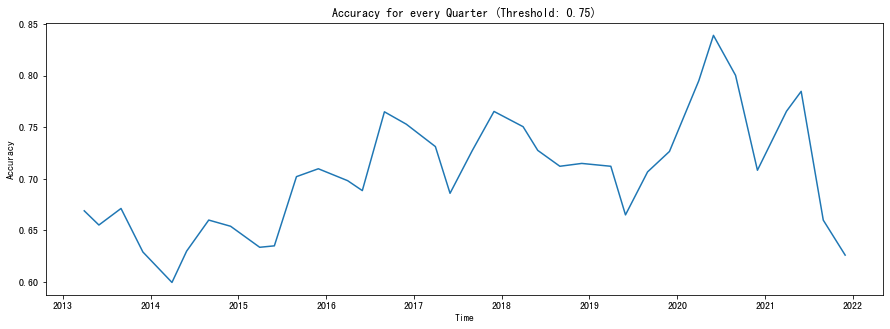

In [14]:
import matplotlib.pyplot as plt

%matplotlib inline
fig = plt.figure(figsize=(15,5))
# fig = plt.figure()
ax = plt.axes()

# for i in label.index:
ax.plot(date_tmp, acc_tmp)

ax.set_title('Accuracy for every Quarter (Threshold: 0.75)')
ax.set_xlabel('Time')  # Add an x-label to the axes.
ax.set_ylabel('Accuracy')  # Add a y-label to the axes.
# ax.legend();  # Add a legend.

# Start to print real performance

# Export WB Score

In [55]:
WB_Score = WB_Score.reindex(sorted(WB_Score.columns), axis=1)
WB_Score.columns = pd.to_datetime(WB_Score.columns)

WB_Score.to_csv('WB_Score.csv')
WB_Score.to_csv('/Users/arthur/Desktop/bbmarket/index_data/WB_Score.csv')

In [65]:
from openpyxl import load_workbook

observed_time = []

for i in range(2010, 2023):
    for j in [4, 6, 9, 12]:
        observed_time.append(datetime.date(i, j, 1) - datetime.timedelta(days=1))

# observed_time = pd.to_datetime(observed_time).dt.date
observed_time  = pd.Index(observed_time[1:])
observed_time  = observed_time.astype('datetime64[ns]')

def export(df, name):
    df = df.loc[df.index.isin(observed_time), :]
    df.T.to_excel(writer, sheet_name=name)
    print(df)

FilePath = '/Users/arthur/Desktop/factor_investment/計算溢酬/CTBCdata/factorvalues_sentiment.xlsx'
ExcelWorkbook = load_workbook(FilePath)
writer = pd.ExcelWriter(FilePath, engine = 'openpyxl')
writer.book = ExcelWorkbook
export(WB_Score, 'WB')
writer.save()
writer.close()

                1101      1102      1103      1104      1108      1109  \
2013-03-31  0.511473   0.44978  0.733965  0.709428  0.531481  0.618143   
2013-05-31  0.629158   0.51533  0.969258       NaN  0.446448  0.268136   
2013-08-31  0.556523    0.5193  0.528078  0.523991  0.515503  0.456545   
2013-11-30  0.563386  0.619119   0.65599  0.662241  0.462376  0.591469   
2014-03-31  0.502028  0.458135  0.539356  0.510225  0.471654  0.563926   
2014-05-31  0.488352  0.473491  0.363789       NaN  0.549797  0.479073   
2014-08-31   0.48402  0.607301   0.42977  0.294631  0.500332  0.553572   
2014-11-30  0.450438  0.477211  0.424383  0.451231   0.52332  0.504478   
2015-03-31  0.491549  0.541485  0.546865  0.540103  0.476797  0.582974   
2015-05-31  0.371083  0.284536  0.503653  0.654916    0.3472   0.40572   
2015-08-31  0.484814  0.609562  0.967414  0.469849  0.374553  0.471572   
2015-11-30  0.438939  0.528287  0.521618  0.559549  0.568507  0.388684   
2016-03-31  0.497177   0.63128       N

In [37]:
sum(factorValues == float('nan'))

array([0, 0])

In [ ]:
set_keepawake(keep_screen_awake=False)

In [1]:
# for i in test.iloc[0, :]:
#     print(i, end=', ')

In [2]:
# test.iloc[0, 60]

In [3]:
# test.iloc[0, [30+i*30 for i in range(100) ]].values

In [145]:
test = pd.read_csv('/Users/arthur/Desktop/Event_Driven_Stock_Prediction_using_Deep_Learning/input2/stockFeatures_ForCNN/2021/9/featureMatrix_1_test.csv', index_col=0)

In [146]:
test = test.iloc[:, 0:-1]
test

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,0.041729,0.081214,0.137409,-0.006161,-0.021783,0.076259,0.007179,-0.024043,-0.016506,0.059677,...,-0.030093,-0.019192,-0.035343,0.060725,-0.016270,0.027782,0.024463,0.021827,-0.023370,-0.020658
1,0.041729,0.081214,0.137409,-0.006161,-0.021783,0.076259,0.007179,-0.024043,-0.016506,0.059677,...,-0.030093,-0.019192,-0.035343,0.060725,-0.016270,0.027782,0.024463,0.021827,-0.023370,-0.000307
2,-0.080618,0.107753,0.053786,-0.144949,-0.071984,-0.029293,-0.031646,0.155230,-0.137353,-0.011311,...,-0.005804,0.068548,-0.014582,-0.024460,0.033537,0.052831,-0.031192,0.029826,0.055976,-0.007922
3,-0.080618,0.107753,0.053786,-0.144949,-0.071984,-0.029293,-0.031646,0.155230,-0.137353,-0.011311,...,-0.005804,0.068548,-0.014582,-0.024460,0.033537,0.052831,-0.031192,0.029826,0.055976,0.015773
4,-0.080618,0.107753,0.053786,-0.144949,-0.071984,-0.029293,-0.031646,0.155230,-0.137353,-0.011311,...,-0.005804,0.068548,-0.014582,-0.024460,0.033537,0.052831,-0.031192,0.029826,0.055976,-0.002858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.221846,0.043292,-0.111182,0.107233,0.000472,-0.000610,-0.042881,0.115499,-0.028732,0.091086,...,-0.041007,0.011612,-0.028894,0.049136,-0.043091,-0.008353,-0.075648,0.014920,-0.048317,-0.017508
996,0.221846,0.043292,-0.111182,0.107233,0.000472,-0.000610,-0.042881,0.115499,-0.028732,0.091086,...,-0.041007,0.011612,-0.028894,0.049136,-0.043091,-0.008353,-0.075648,0.014920,-0.048317,-0.037570
997,0.043163,-0.052672,-0.010913,-0.028099,0.021364,0.027318,0.080445,0.064056,-0.011381,0.024795,...,0.016905,-0.031338,-0.029169,-0.067369,-0.038294,-0.008465,-0.004117,-0.014109,0.014053,0.010329
998,0.043163,-0.052672,-0.010913,-0.028099,0.021364,0.027318,0.080445,0.064056,-0.011381,0.024795,...,0.016905,-0.031338,-0.029169,-0.067369,-0.038294,-0.008465,-0.004117,-0.014109,0.014053,0.003114


In [148]:
test = test.values.reshape(test.shape[0], 30, 100, 1).astype('float32')
test

array([[[[ 0.04172898],
         [ 0.08121415],
         [ 0.13740897],
         ...,
         [-0.01786909],
         [ 0.13633274],
         [ 0.11209206]],

        [[-0.09187528],
         [-0.07041948],
         [-0.02561705],
         ...,
         [ 0.02664191],
         [ 0.06920198],
         [ 0.01303281]],

        [[ 0.01193049],
         [-0.02353893],
         [ 0.00947749],
         ...,
         [-0.04248001],
         [-0.02208451],
         [-0.00558802]],

        ...,

        [[-0.10909837],
         [-0.11048172],
         [ 0.09033615],
         ...,
         [-0.01489004],
         [ 0.08225919],
         [-0.04648369]],

        [[-0.04865576],
         [ 0.0096346 ],
         [-0.02643079],
         ...,
         [ 0.002421  ],
         [ 0.02164278],
         [-0.00797193]],

        [[-0.00427755],
         [-0.03739626],
         [-0.05680646],
         ...,
         [ 0.02182685],
         [-0.0233695 ],
         [-0.02065841]]],


       [[[ 0.04172898],
